In [1]:
from random import seed
from random import randrange
from sklearn import datasets
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
from sklearn.preprocessing import LabelEncoder
import multiprocessing as mp
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

Random forest version 1

In [2]:
class Tree:
    def __init__(self):
        pass
    
    def fit(self,features,X,y):
        self.features = features
        tree_x = X[:,features]
        self.clf = DecisionTreeClassifier()
        self.clf.fit(tree_x,y)
    
    def predict(self,X):
        tree_x = X[:,self.features]
        predictions = self.clf.predict(tree_x)
        return predictions

In [5]:
class RandomForest:
    
    def __init__(self,number_trees,sample_fraction=1):
        self.number_trees = number_trees
        self.sample_fraction = sample_fraction
    
    def fit(self,X,y):
        trees = []
        n_features = int(np.sqrt(len(X[0])))
        n_samples = len(X)*self.sample_fraction
        for _ in range(self.number_trees):
            features = np.random.choice(len(X[0]), n_features,replace=False)
            samples = np.random.choice(len(X),n_samples,replace=False)
            tree_y,tree_x = y[samples], X[samples]
            tree = Tree ()
            tree.fit(features,tree_x,tree_y)
            trees.append(tree)
        self.trees = trees
    
    def predict(self,X):
        prediction_matrix = [[] for _ in range(len(X))]
        for tree in self.trees:
            predictions = tree.predict(X)
            for curr,all_ in zip(predictions,prediction_matrix):
                all_.append(curr)
        final_predictions = []
        for row in prediction_matrix:
            counter = Counter(row)
            prediction = counter.most_common(1)[0][0]
            final_predictions.append(prediction)
        return final_predictions
        

In [3]:
iris = datasets.load_iris()

In [6]:
rf = RandomForest(10000)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(iris.data,iris.target)

In [10]:
rf.fit(X_train,y_train)

In [11]:
preds= rf.predict(X_test)
accuracy_score(preds,y_test)

0.8947368421052632

In [14]:
sklearn_rf = RandomForestClassifier()
sklearn_rf.fit(X_train,y_train)
sklearn_preds = sklearn_rf.predict(X_test)

/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [15]:
accuracy_score(sklearn_preds,y_test)

0.868421052631579

In [7]:
max_workers = mp.cpu_count()  
max_workers

8

In [8]:
n_features_iris = int(np.sqrt(len(iris.data[0])))
n_trees_iris = 10000

In [9]:
def fit_tree_iris(tree):
    features = np.random.choice(len(iris.data[0]), n_features_iris,replace=False)
    tree.fit(features,iris.data,iris.target)
    return tree

In [10]:
def get_workers_to_time(fit_tree,num_trees=10,max_workers=8):
    workers = []
    times = []
    trees = [Tree() for _ in range(num_trees)]
    for num_workers in range(1,max_workers+1):
        workers.append(num_workers)
        pool = mp.Pool(num_workers)
        start = timer()
        pool.map(fit_tree,trees)
        end = timer()
        time = end - start
        times.append(time)
        pool.close()
        pool.join()
    return workers,times

In [11]:
workers,times = get_workers_to_time(fit_tree_iris,num_trees=n_trees_iris)

In [12]:
def plt_results(workers,times,name,num_trees):
    plt.plot(workers,times)
    plt.xlabel("Number of Workers")
    plt.ylabel("Time in seconds")
    plt.title("Time to train {} trees on the {} dataset".format(num_trees,name))
    plt.show()

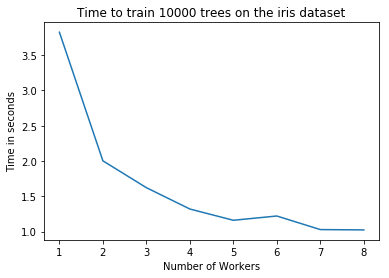

In [32]:
plt_results(workers,times,"iris",n_trees_iris)

Time to train the random forest and the number of workers are inversely related. That is time to train that random forest is roughly equal to M/n (Where M is the time to take to train the model and n is the number of workers). We want to establish a direct relationship so therefore we will measure training speed which we will establish as 1/training time. Training speed will therefore be equal to M/n

In [67]:
def plt_speeds(workers,times,name,num_trees):
    rates = [1/time for time in times]
    plt.plot(workers,rates)
    plt.xlabel("Number of Workers")
    plt.ylabel("Training speed (inverse of training time)")
    plt.title("Training speed to train {} trees on the {} dataset".format(num_trees,name))
    plt.show()

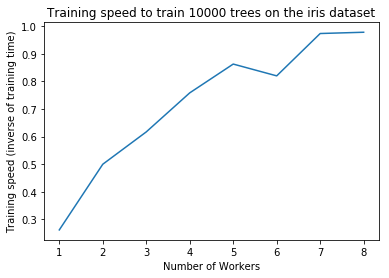

In [36]:
plt_speeds(workers,times,"iris",n_trees_iris)

In [16]:
breast = datasets.load_breast_cancer()

In [24]:
num_trees_breast = 160
n_features_breast = int(np.sqrt(len(breast.data[0])))

In [25]:
def fit_tree_breast(tree):
    features = np.random.choice(len(breast.data[0]), n_features_breast,replace=False)
    tree.fit(features,breast.data,breast.target)
    return tree

In [26]:
workers_breast,times_breast = get_workers_to_time(fit_tree_breast,num_trees=num_trees_breast)

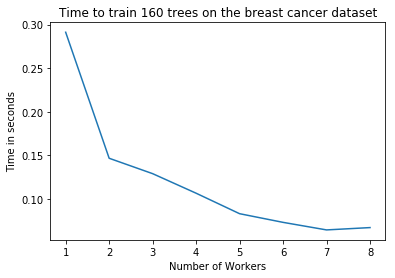

In [27]:
plt_results(workers_breast,times_breast,"breast cancer",num_trees_breast)

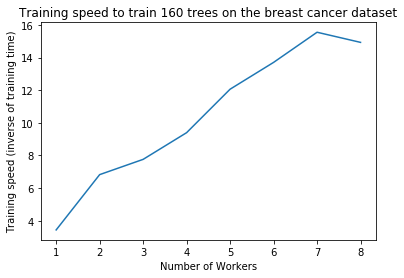

In [38]:
plt_speeds(workers_breast,times_breast,"breast cancer",num_trees_breast)

In [41]:
digits = datasets.load_digits()

In [42]:
num_trees_digits = 16
n_features_digits = int(np.sqrt(len(digits.data[0])))

In [43]:
def fit_tree_digits(tree):
    features = np.random.choice(len(digits.data[0]), n_features_digits,replace=False)
    tree.fit(features,digits.data,digits.target)
    return tree

In [44]:
workers_digits,times_digits = get_workers_to_time(fit_tree_digits,num_trees=num_trees_digits)

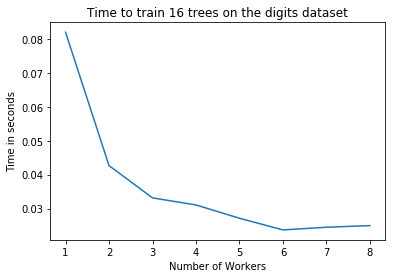

In [45]:
plt_results(workers_digits,times_digits,"digits",num_trees_digits)

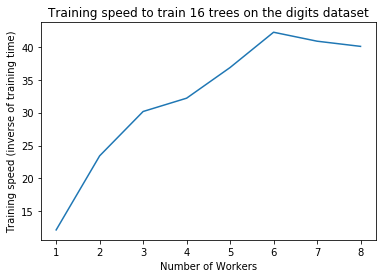

In [46]:
plt_speeds(workers_digits,times_digits,"digits",num_trees_digits)

In [48]:
human_activity_df = pd.read_csv("human_activity.csv").drop('Unnamed: 0',1)

In [49]:
human_activity_x = human_activity_df.drop("label", 1).values
human_activity_y = human_activity_df["label"].values

In [50]:
num_trees_human = 16
n_features_human = int(np.sqrt(len(human_activity_x[0])))

In [51]:
def fit_tree_human(tree):
    features = np.random.choice(len(human_activity_x[0]), n_features_digits,replace=False)
    tree.fit(features,human_activity_x,human_activity_y)
    return tree

In [52]:
workers_human,times_human = get_workers_to_time(fit_tree_human,num_trees=num_trees_human)

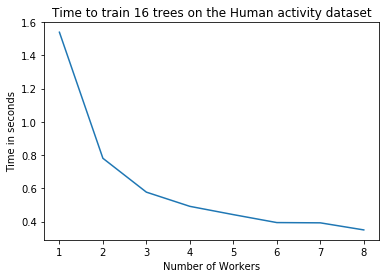

In [53]:
plt_results(workers_human,times_human,"Human activity",num_trees_human)

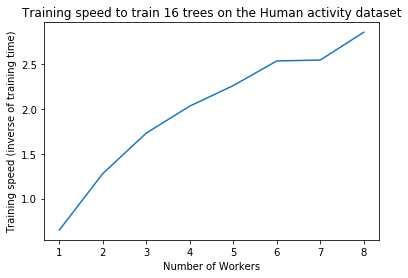

In [54]:
plt_speeds(workers_human,times_human,"Human activity",num_trees_human)

In [55]:
workers_matrix = np.asmatrix([workers]).T

In [56]:
reg = LinearRegression()

In [62]:
reg.fit(workers_matrix,times)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [63]:
reg.score(workers_matrix,times)

0.6446713264844726

In [57]:
speeds = [1/time for time in times]

In [65]:
reg.fit(workers_matrix,speeds)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

By predicting 1/time instead of time we increased the r^2 coeficient dramatically

In [66]:
reg.score(workers_matrix,speeds)

0.903611159042741